# CSCE 623 Homework Assignment 5

### Student Name:  HOSLEY, BRANDON

### Date: May 18, 2023

### Solving Common Problems

Instructions:
* Review all provided code before starting your work - this instructor has provided hints and tips throughout the code
* This assignment is composed of 3 parts (3 case studies)
    * Each part is designed to be a standalone snippet of a machine learning activity which contains flaws
    * Your goal is to identify the flaw by performing steps required to diagnose the flaws
    
* In each case, you will complete several steps
    * CODE CELL (diagnostics): Write code to diagnose the problem and produce evidence of the issue (e.g. print statements, tables, and graphs).  
    (IMPORTANT - Even if you can see the flaw directly in the provided code you must include code here to demonstrate the flaw to show evidence of it - failing to do so will result in not achieving full score on the assignment.)
    * MARKDOWN CELL: Describe the problem and how to solve it in a markdown cell (English text)
    * CODE CELL (solution): Solve the issues so the ML task works properly
    
* Additional Requirements / Considerations
    * While you may inspect the performance on the test set during diagnosis, you should not use the test set to fix the issue.  All decisionmaking (e.g. hyperparameter selection) should be conducted on the non-test set.
    * Some form of validation such as validation, crossvalidation or LOOCV should be used for hyperparameter tuning (dont just tune on the training set)
    * Ensure your choices for hyperparameter decisions and rationale for using them are displayed/explained in code and/or markdown cells
    * Make decisions algorithmically (avoid hardcoding values)

* Remember to restart the kernel and rerun all cells before submitting the assignment
* Submit only the Jupyter Notebook (.ipynb) file - do not submit the datasets.

In [1]:
# Note... not all of these are used...

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import copy

from math import factorial

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate,  cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import mean_squared_error, make_scorer, average_precision_score, recall_score, accuracy_score, precision_score, confusion_matrix

from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, RocCurveDisplay 


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.feature_selection import SequentialFeatureSelector

%matplotlib inline
plt.style.use('seaborn-white')

from IPython.display import Markdown as md

import warnings
#warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

## OPTIONAL STUDENT CODING: If you need any imports, code them below

In [2]:
######### ------- EXTRA STUDENT IMPORTS ------------

from sklearn.metrics import precision_recall_fscore_support

######### ------- END STUDENT IMPORTS ------------

In [3]:
#helper functions provided by instructor

def data_explore(df):
    

    display(md('Data Statistics:'))
    display(df.describe())
    display(md('Class 0 Statistics:'))
    display(df.loc[df.Class==0,:].describe())
    display(md('Class 1 Statistics:'))
    display(df.loc[df.Class==1,:].describe())
    display(md('Covariance of Class 0:'))
    display(df.loc[df.Class==0,['X1','X2']].cov())
    display(md('Covariance of Class 1:'))
    display(df.loc[df.Class==1,['X1','X2']].cov())
    sns.pairplot(df, hue="Class", height=5)
    df.loc[df.Class==0,:].hist(grid=False, layout=(1,3), figsize=(12,4));
    df.loc[df.Class==1,:].hist(grid=False, layout=(1,3), figsize=(12,4));
    

    
def predict_probs(models, X):
    """ Returns a dictionary of predicted proability vectors using models stored in the input dictionary 'models' on the feature data 'X'
    params:  
    models - a dictionary of fitted classification models with key equal to the name of the model
    X - the values of a dataset obtained"""
    predicts = {}
    
    for key, model in models.items():
        predicts[key] = model.predict_proba(X)
    return predicts    

------------------------------------
# CASE 1

The aspiring machine learning novice is trying to build a simple logistic regression classifier to fit a 2-feature, 2 class dataset, but the outcome is not as expected... you must rescue them from their uncertain fate!

------------------------------------

### Case 1 - Load data & explore:

Data Statistics:

,X1,X2,Class
count,1000.000000,1000.000000,1000.000000
mean,0.284649,-0.007965,0.255000
std,0.639555,0.502198,0.436079
min,-1.301051,-1.474840,0.000000
25%,-0.160430,-0.352626,0.000000
50%,0.224621,-0.027862,0.000000
75%,0.702444,0.346045,1.000000
max,2.188683,1.765224,1.000000


Class 0 Statistics:

,X1,X2,Class
count,745.000000,745.000000,745.0
mean,0.038584,-0.025403,0.0
std,0.476093,0.500715,0.0
min,-1.301051,-1.474840,0.0
25%,-0.273378,-0.358700,0.0
50%,0.036290,-0.029248,0.0
75%,0.347024,0.318305,0.0
max,1.481068,1.765224,0.0


Class 1 Statistics:

,X1,X2,Class
count,255.000000,255.000000,255.0
mean,1.003544,0.042983,1.0
std,0.498380,0.504038,0.0
min,-0.214128,-1.292231,1.0
25%,0.647435,-0.325041,1.0
50%,0.995023,-0.011687,1.0
75%,1.377932,0.416004,1.0
max,2.188683,1.325965,1.0


Covariance of Class 0:

,X1,X2
X1,0.226664,-0.009245
X2,-0.009245,0.250716


Covariance of Class 1:

,X1,X2
X1,0.248383,0.019030
X2,0.019030,0.254054


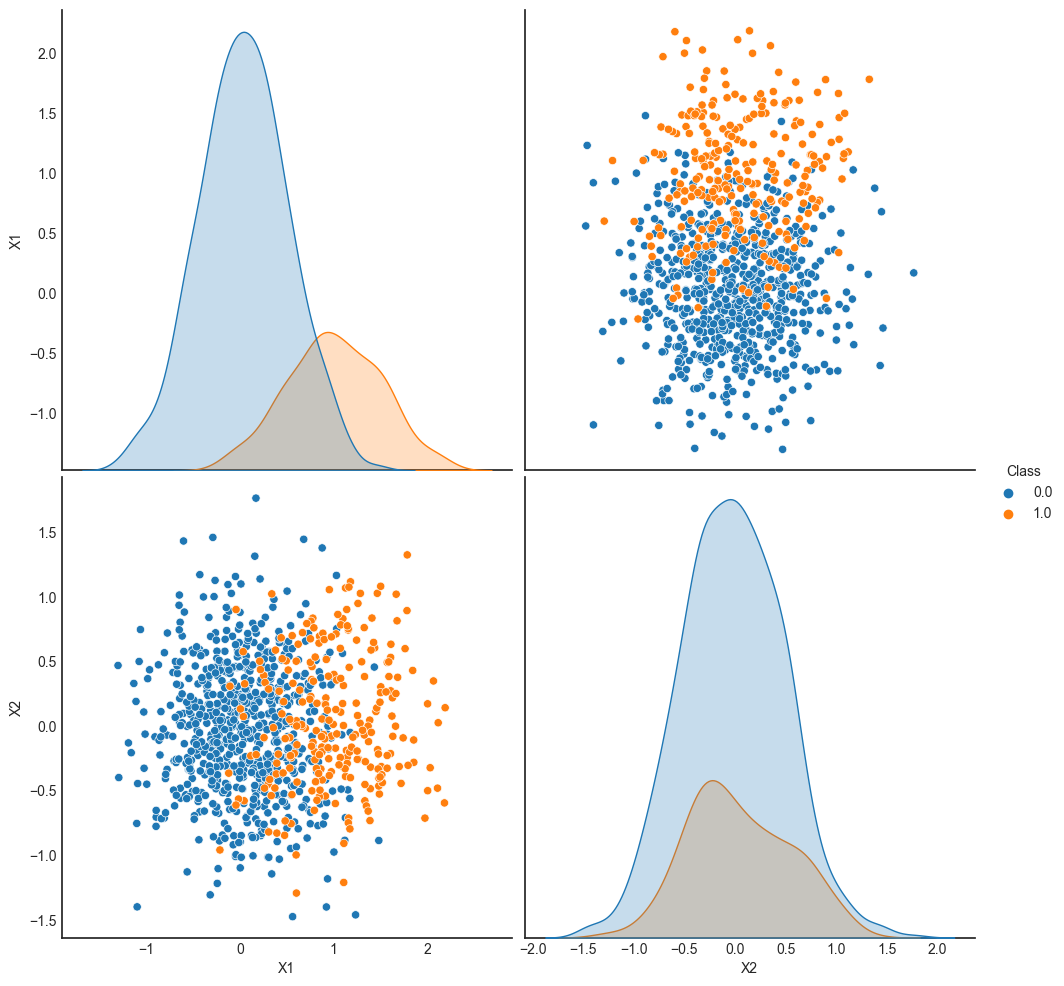

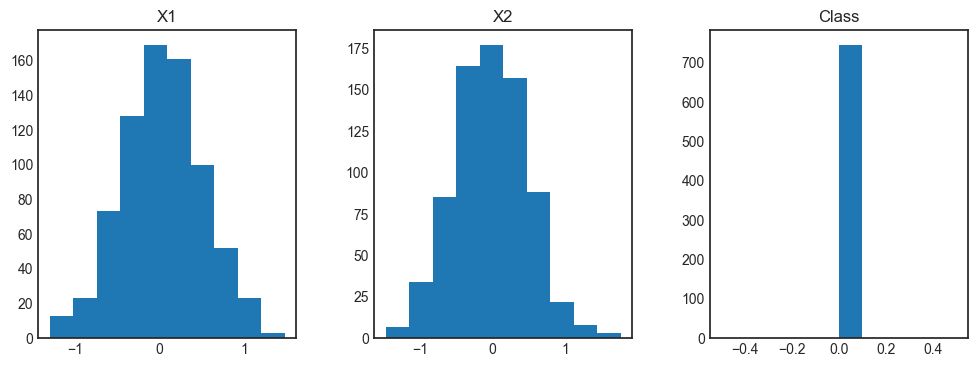

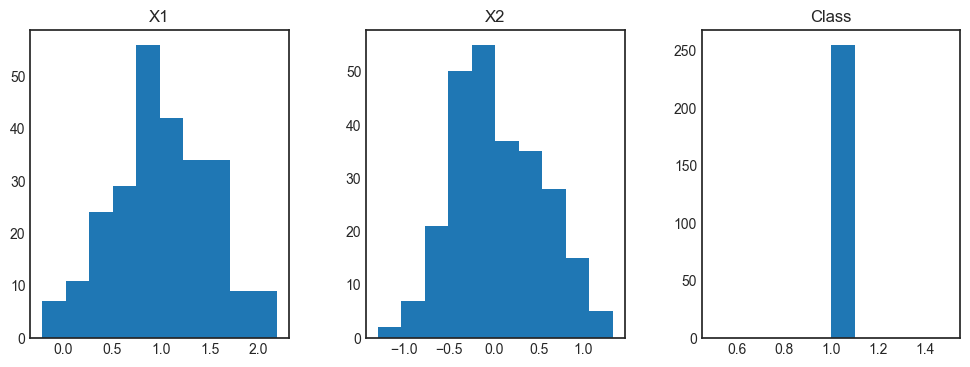

In [4]:
#load dataset
# c1_df = pd.read_csv("c1_data.csv")
c1_df = pd.read_csv('c1_data.csv', header=0, names=['X1','X2','Class'], index_col=0)



#visualize/explore the dataset
data_explore(c1_df)


    



### Case 1 - Split test & non-test, fit a model and evaluate performance

In [5]:
#split into test & training
tngfrac = 0.75  # 25 percent of data used for test, rest for non-test
tngqty = np.ceil(tngfrac*len(c1_df)).astype(int)
c1_non_test_df, c1_test_df= c1_df[:tngqty], c1_df[tngqty:]
 

#fit a model
c1_model = LogisticRegression()
feature_cols = ['X1','X2']
c1_model.fit(c1_non_test_df[feature_cols],c1_non_test_df.Class)

#check performance on non-test set
non_test_cv_scores = cross_val_score(c1_model, c1_non_test_df[feature_cols], c1_non_test_df.Class, cv=5)
print("\n\n\nNon-test mean accuracy from 5-fold CV", np.mean(non_test_cv_scores))

#eval performance on test set
yhat = c1_model.predict(c1_test_df[feature_cols])
test_score = c1_model.score(c1_test_df[feature_cols], c1_test_df['Class'])
print("\nTest set accuracy:", test_score)
print("\n\n")




Non-test mean accuracy from 5-fold CV 0.9933333333333334

Test set accuracy: 0.0





### C1 ISSUE & TASK:

The 5-fold crossval performance of a model on the non-training data looks very good, but the test set performance is bad.  

Your job is to figure out why.   In the areas below, complete the following steps

1.  Use the student code area below to diagnose the problem (use any tools you have learned in the class to do this).  Once you figure out what the problem is, make sure it is clearly presented using code to visualize/print evidence of the problem
2.  Use the markdown area after the code cell to describe the problem
3.  Solve the problem in the designated code cell after the markdown cell by copying the above cells and fixing errors to resolve the performance gap.   

Hint:  Your CV performance and your test performance should be similar and both should be better than chance on this dataset.

## Case 1 Diagnostics to discover the problem (STUDENT CODE REQUIRED)

In [6]:
# CASE 1 DIAGNOSTICS

# --------- START STUDENT CODE -------------
print('The class counts for the training dataset is/are: ', c1_non_test_df.Class.value_counts() )
print('The class counts for the test dataset is/are: ', c1_test_df.Class.value_counts() )
# --------- END STUDENT CODE -------------




The class counts for the training dataset is/are:  0.0    745
1.0      5
Name: Class, dtype: int64
The class counts for the test dataset is/are:  1.0    250
Name: Class, dtype: int64


## CASE 1 Explanation and plan for solution (STUDENT MARKDOWN REQUIRED)

In the markdown cell below, describe the problem/mistake the novice made and describe your plan for fixing the issue

<font color='green'>STUDENT ANSWER BELOW</font>   

On the first read- through it appears that there was an issue with the data split. The data is currently organized such that the entire negative class exists in front of the entire positive class. The train/test split was performed in a deterministic manner, based on the ordered data. Had the split been `tngfrac = 0.755` instead, the training accuracy would be raised to 100%, and remain zero on the test set. Addressing that issue should greatly improve the performance of this model.

## CASE 1 Solution (STUDENT CODE REQUIRED)

In this step, fix the problem, run CV make sure you print your mean test set accuracy from crossvalidation.

If working correctly, your CV and Test set accuracies should be within a few percent of each other.

### Display the mean CV accuracy and Test Set Accuracy


In [7]:
# CASE 1 SOLUTION

myrandstate = 42
mean_cv_accuracy = None #placeholder
test_accuracy = None #placeholder

c1_model = LogisticRegression()
feature_cols = ['X1','X2']

# --------- START STUDENT CODE -------------

#take the steps to fix the problem and fit the c1_model 

#split into test & training
tngfrac = 0.75  # 25 percent of data used for test, rest for non-test
c1_non_test_df, c1_test_df= train_test_split(c1_df, train_size= tngfrac, random_state=myrandstate)
 

#fit a model
c1_model = LogisticRegression()
feature_cols = ['X1','X2']
c1_model.fit(c1_non_test_df[feature_cols],c1_non_test_df.Class)

mean_cv_accuracy = np.mean(cross_val_score(c1_model, c1_non_test_df[feature_cols], c1_non_test_df.Class, cv=5))

# --------- END STUDENT CODE -------------

#eval performance on test set
yhat = c1_model.predict(c1_test_df[feature_cols])
test_accuracy = c1_model.score(c1_test_df[feature_cols], c1_test_df['Class'])

print("\n\n\nNon-test mean accuracy from 5-fold CV", mean_cv_accuracy)
print("\nTest set accuracy:", test_accuracy)
print("if working well, CV accuracy should be close to test accuracy")
print("\n\n\n\n")






Non-test mean accuracy from 5-fold CV 0.8746666666666666

Test set accuracy: 0.856
if working well, CV accuracy should be close to test accuracy







------------------------------------
# CASE 2

The aspiring machine learning novice is trying to build a KNN classifier to fit a 200-feature, 2 class dataset, but the 5-fold cv performance is far lower than desired.  Our novice consults with a colleague who brags about being able to achieve over 70% accuracy with KNN on the dataset but the braggart refuses to help the novice.   

Only you can save our novice!

------------------------------------

In [8]:
myrandstate = 42

c2_df = pd.read_csv('c2_data.csv', header=0, index_col=0)

#test / non-test split
tngfrac = 0.75
c2_non_test_df, c2_test_df= train_test_split(c2_df, train_size = tngfrac, stratify=c2_df.Class, random_state=myrandstate)


display(c2_non_test_df.describe())


#instantiate a model
c2_model = KNeighborsClassifier(n_neighbors=1)

#check performance on non-test set using cross-validation
non_test_cv_scores = cross_val_score(c2_model,
                                     c2_non_test_df.loc[:, c2_non_test_df.columns != "Class"],
                                     c2_non_test_df.Class, cv=5)
print("\n\n\nNon-test mean accuracy from 5-fold CV", np.mean(non_test_cv_scores))

#fit a model
c2_model.fit(c2_non_test_df.loc[:, c2_non_test_df.columns != "Class"],c2_non_test_df.Class)


#eval performance on test set
yhat = c2_model.predict(c2_test_df.loc[:, c2_test_df.columns != "Class"])
test_score = c2_model.score(c2_test_df.loc[:, c2_test_df.columns != "Class"], c2_test_df['Class'])
print("\nTest set accuracy:", test_score)
print("\n\n\n\n")

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Class
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,-0.007736,0.013069,-0.008207,0.022259,-0.000260,0.006012,-0.000960,0.019352,-0.024470,-0.016659,...,0.001813,-0.016389,0.037004,0.015411,-0.001052,-0.000067,-0.005127,-0.010025,-0.030247,0.500000
std,0.465729,0.446784,0.455333,0.449283,0.457167,0.471359,0.452657,0.447693,0.466559,0.431094,...,0.450937,0.445578,0.455908,0.434098,0.452291,0.445753,0.456673,0.442513,0.456974,0.500334
min,-1.478735,-1.595918,-1.341709,-1.212968,-1.486827,-1.311335,-1.655204,-1.290833,-1.412928,-1.341528,...,-1.736781,-1.316011,-1.473764,-1.405714,-1.782064,-1.644237,-1.759269,-1.237552,-1.367068,0.000000
25%,-0.328987,-0.271021,-0.303371,-0.286203,-0.287847,-0.318655,-0.327382,-0.287877,-0.334022,-0.310146,...,-0.305370,-0.307683,-0.267304,-0.258255,-0.279207,-0.306073,-0.280282,-0.310762,-0.352978,0.000000
50%,-0.000059,-0.003899,-0.007134,0.010918,0.011396,-0.002103,-0.017478,0.003899,-0.044617,-0.016667,...,-0.014188,-0.018647,0.031250,0.011812,0.012030,-0.003153,0.011381,0.001813,-0.047426,0.500000
75%,0.305822,0.298579,0.297638,0.326316,0.313035,0.346940,0.314125,0.298058,0.293455,0.265325,...,0.308673,0.269164,0.337552,0.318166,0.298825,0.314531,0.299796,0.258441,0.284725,1.000000
max,1.554333,1.511654,1.414674,1.522692,1.605635,1.481025,1.395317,1.339477,1.608782,1.263242,...,1.585773,1.670259,1.477562,1.233595,1.406474,1.279714,1.543303,1.626814,1.523908,1.000000





Non-test mean accuracy from 5-fold CV 0.572

Test set accuracy: 0.576







Text(0, 0.5, 'Accuracy Score')

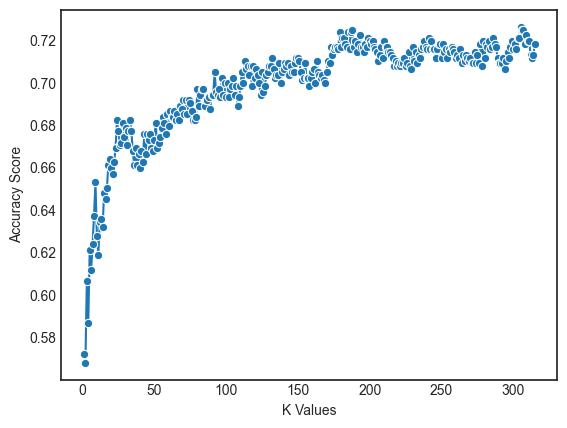

In [9]:
#CASE 2 DIAGNOSTICS


# --------- START STUDENT CODE -------------
k_values = [i for i in range (1,int(10*np.sqrt(len(c2_df))))]
#k_values = [i for i in range (1,int(2*np.sqrt(len(c2_df))))]
c2_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, c2_non_test_df.loc[:, c2_non_test_df.columns != "Class"],
                            c2_non_test_df.Class, cv=5)
    c2_scores.append(np.mean(score))

sns.lineplot(x = k_values, y = c2_scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

# --------- END STUDENT CODE -------------


## CASE 2 Explanation and Plan for Solution (STUDENT MARKDOWN REQURIED)

<font color='green'>STUDENT ANSWER BELOW</font>   

$k=1$ is seldom a good choice. By using this parameter the model is too flexible. The low accuracy in the training set also implies that there is some overlap between the classes. If the classes were more distinctly separated it is probable that this model would be rated as higher in accuracy, but still not a good model even so. As shown in the tests above increasing the k will increase the bias and improve the accuracy at least up to the point tested. A common rule of thumb is to use the square root of the sample count, however, the value $24$ for the test, and $31$ for the whole dataset. These results appear to level out around $100$ and $200$. We will test the k associated with the highest training score in that general range.

## CASE 2 Solution (STUDENT CODE REQURIED) 

Implement your fix to help the novice achieve over 70% accuracy using KNN on the test set.

To achive this fit a new model `c2_fixed_model` on the non-test data

The model you fit will be evaluated on the test data and should achieve a performance around 70% accuracy

### Display the test set accuracy. 

In [10]:
#CASE 2 SOLUTION

c2_fixed_model = None  #placeholder for the model you will fit

# --------- START STUDENT CODE -------------

# take actions and fit a c2_fixed_model that will do well on the test set
c2_k = c2_scores.index(max(c2_scores[:250]))

c2_fixed_model = KNeighborsClassifier(n_neighbors= c2_k)
c2_fixed_model.fit(c2_non_test_df.loc[:, c2_non_test_df.columns != "Class"],c2_non_test_df.Class)

non_test_cv_scores = cross_val_score(c2_fixed_model,
                                     c2_non_test_df.loc[:, c2_non_test_df.columns != "Class"],
                                     c2_non_test_df.Class, cv=5)
print(f"\nNon-test mean accuracy from 5-fold CV, with k={c2_k} is ", np.mean(non_test_cv_scores))

# --------- END STUDENT CODE -------------

# determine test set performance
yhat = c2_fixed_model.predict(c2_test_df.loc[:, c2_test_df.columns != "Class"])
test_accuracy = c2_fixed_model.score(c2_test_df.loc[:, c2_test_df.columns != "Class"], c2_test_df['Class'])

print("\nTest set accuracy:", test_accuracy)
print("\n\n\n\n")


Non-test mean accuracy from 5-fold CV, with k=187 is  0.724

Test set accuracy: 0.716







------------------------------------
# CASE 3

The ML Novice is tackling a customer requirement.  The customer wants to make a classifier for a targeting system which has maximally high precision - Ideally, as many possible true targets are found and there are zero false positives.  The catch is that the customer wants to use QDA for this model and that they want a solution which has perfect precision (1) and finds the maximum number of targets when precision is perfect.  Model tuning should happen on the non-test set and performance evaluation/reporting on the test set.

Unfortunately, things are not going well for our novice... see if you can help!

------------------------------------

Data Statistics:

,X1,X2,Class
count,300.000000,300.000000,300.000000
mean,0.485577,2.419698,0.500000
std,3.671341,4.281530,0.500835
min,-11.007206,-6.091856,0.000000
25%,-1.492858,-0.482966,0.000000
50%,0.805101,1.570589,0.500000
75%,2.709781,5.045929,1.000000
max,12.062268,20.120173,1.000000


Class 0 Statistics:

,X1,X2,Class
count,150.000000,150.000000,150.0
mean,-0.158917,0.298576,0.0
std,4.728043,2.420554,0.0
min,-11.007206,-6.091856,0.0
25%,-3.231226,-1.390663,0.0
50%,0.064067,0.238098,0.0
75%,3.046822,1.769157,0.0
max,12.062268,6.951659,0.0


Class 1 Statistics:

,X1,X2,Class
count,150.000000,150.000000,150.0
mean,1.130072,4.540820,1.0
std,1.963986,4.676348,0.0
min,-3.761491,-5.187811,1.0
25%,0.083922,1.325519,1.0
50%,1.137775,4.216949,1.0
75%,2.541925,7.550244,1.0
max,6.669109,20.120173,1.0


Covariance of Class 0:

,X1,X2
X1,22.354392,6.370066
X2,6.370066,5.859081


Covariance of Class 1:

,X1,X2
X1,3.857243,-2.150509
X2,-2.150509,21.868233


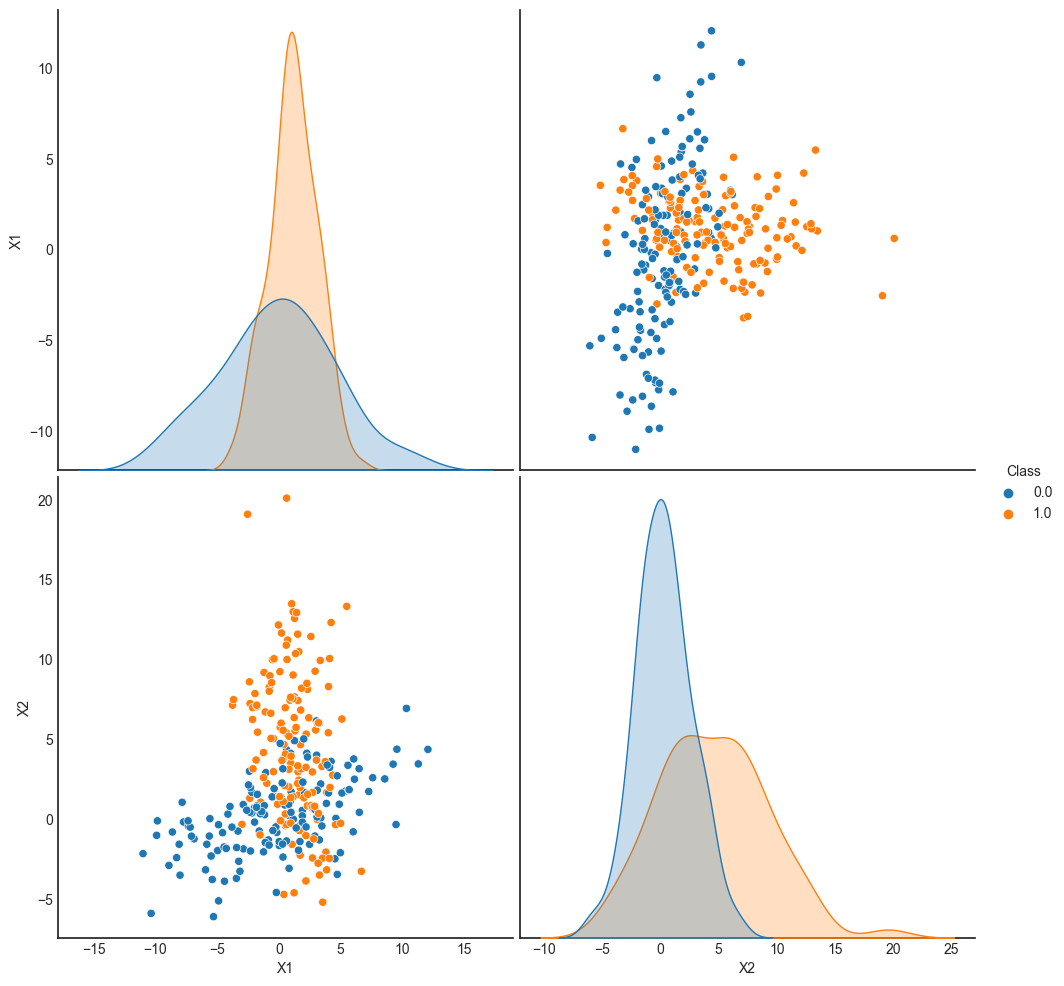

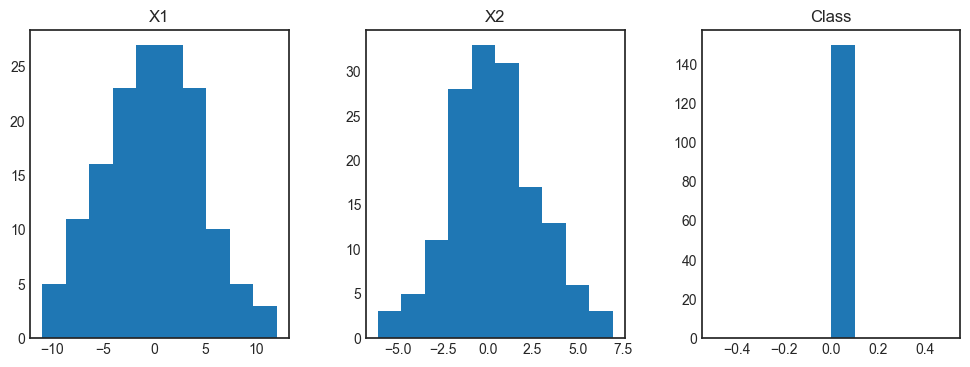

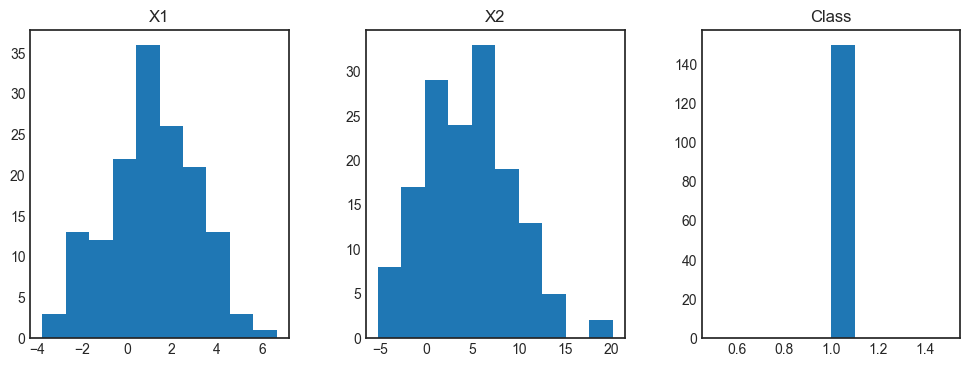

In [11]:

randstate = 42

#load the data
c3_df = pd.read_csv('c3_data.csv', header=0, names=['X1','X2','Class'], index_col=0)

#split test & nontest
c3_non_test_df,c3_test_df = train_test_split(c3_df,test_size=0.5,random_state=randstate, stratify=c3_df.Class)
#explore the non-test data
data_explore(c3_non_test_df)

In [12]:
#subset the training data into features and labels
X = c3_non_test_df.loc[:,['X1','X2']]
y = c3_non_test_df.loc[:,['Class']].values.ravel()

#instantiate qda model
qda = QuadraticDiscriminantAnalysis()
# qda = LinearDiscriminantAnalysis()
qda.fit(X, y)



kfold_count = 5

non_test_cv_precision=np.mean(cross_val_score(estimator = QuadraticDiscriminantAnalysis(), scoring=make_scorer(precision_score),
                                    X=X,
                                    y=y,
                                    cv=kfold_count))

print("Non-test set cv precision:",non_test_cv_precision)


#obtain prediction probs on test set using the model fit previously on the non-test data
preds_test = qda.predict_proba(c3_test_df.loc[:,['X1','X2']])

#classify the prediction probabilities
desired_precision = 1.0
y_hat_test = (preds_test[:,1]>=desired_precision)*1.0

predPos = y_hat_test==1 
truePos = predPos&(c3_test_df['Class'].values==1)
prec = sum(truePos*1.0)/sum(predPos*1.0)
print("precision:", prec) 
print("Test Set predicted positives:",sum(truePos*1.0))



Non-test set cv precision: 0.8356178660049627
precision: nan
Test Set predicted positives: 0.0


/var/folders/8h/pt6dnpv520d200zx4xc71ld80000gn/T/ipykernel_50376/1587475349.py:31: RuntimeWarning: invalid value encountered in double_scalars
  prec = sum(truePos*1.0)/sum(predPos*1.0)


## CASE 3 Diagnostics (STUDENT CODE REQUIRED)

So we can see that the novice's model seems to be unacceptably low precision during CV on the non-test set, but on the test set, the model is not predicting *anything* positive and precision cannot even be computed due to the divide by zero error!  This is bad.  Run diagnostics in the cell below to see if you can discover the problem



In [13]:
#CASE 3 DIAGNOSTICS


# --------- START STUDENT CODE -------------

print( preds_test )
print( y_hat_test )

# --------- END STUDENT CODE -------------


[[4.52299300e-03 9.95477007e-01]
 [1.09969086e-02 9.89003091e-01]
 [7.92220212e-01 2.07779788e-01]
 [9.85343657e-01 1.46563427e-02]
 [5.90762493e-01 4.09237507e-01]
 [2.22627757e-01 7.77372243e-01]
 [7.95556682e-08 9.99999920e-01]
 [1.74734107e-04 9.99825266e-01]
 [5.08156609e-01 4.91843391e-01]
 [2.97266627e-01 7.02733373e-01]
 [9.98231736e-01 1.76826400e-03]
 [3.48139345e-08 9.99999965e-01]
 [1.00000000e+00 6.57095566e-14]
 [4.81574838e-02 9.51842516e-01]
 [8.50903296e-01 1.49096704e-01]
 [9.82435823e-01 1.75641775e-02]
 [4.35326095e-02 9.56467391e-01]
 [6.17171829e-01 3.82828171e-01]
 [4.86268443e-01 5.13731557e-01]
 [4.72263407e-01 5.27736593e-01]
 [9.86510527e-01 1.34894735e-02]
 [8.70434133e-01 1.29565867e-01]
 [4.86374253e-01 5.13625747e-01]
 [5.79836308e-01 4.20163692e-01]
 [5.64267604e-01 4.35732396e-01]
 [7.58838141e-01 2.41161859e-01]
 [9.99911922e-01 8.80778279e-05]
 [6.31133959e-01 3.68866041e-01]
 [2.41159271e-03 9.97588407e-01]
 [9.32760550e-01 6.72394501e-02]
 [9.827375

## CASE 3 Explanation and Plan for Solution (STUDENT MARKDOWN REQURIED) 

Describe what you discovered in the diagnostic code you wrote above AND define the plan for how to resolve the issue

<font color='green'>STUDENT ANSWER BELOW</font>   

From the test predictions and the $\hat y$ that is calculated from that we can see that non of the predictions meet the $1.00$ or 100% threshold. The intuition behind this will remain that the highest possible number of targets that can be hit with 100% certainty is 0. The mistake above was treating the decision threshold as equivalent to the desired precision.

In order to address this problem there must be an acceptance of some level of risk. The ML novice will have to understand that customers often are either imprecise or unrealistic in their requirements. It is up to the analyst to provide the education of what is possible and realistic and allow the customer to make the final decision of what constraints they are willing to accept. From this perspective the analyst has a small range of thresholds that they can choose. Below I show the range of thresholds below 1 that still produce perfect precision.

For the test we use approximately the middle threshold of the initial plateau.

## CASE 3 Solution (STUDENT CODE REQUIRED)

In the code cell below, implement a solution which achieves the customer goal of perfect precision with the most possible targets found (maximize true positives).  

### Report the precision and number of true positives found in the test set.

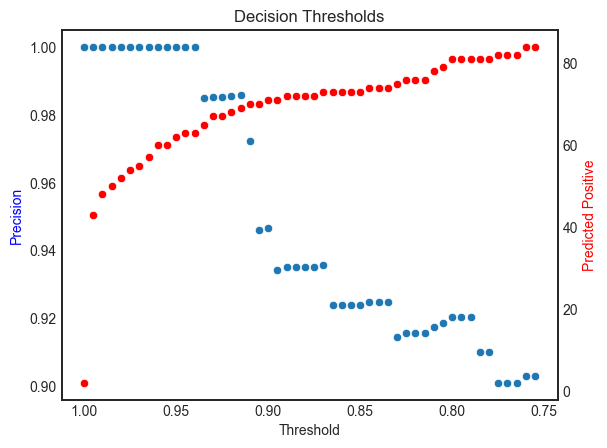

precision: nan
Test Set predicted positives: 59.0


In [14]:
# CASE 3 SOLUTION


test_prec = None #placeholder for test set precision
test_TP =None #placeholder for test set TRUE POSITIVE count (an integer)

X_non_test = c3_non_test_df.loc[:,['X1','X2']].values
y_non_test = c3_non_test_df.Class.values

X_test = c3_test_df.loc[:,['X1','X2']].values
y_test = c3_test_df.Class.values

clf = QuadraticDiscriminantAnalysis()  #you will need to train a model of this type

# --------- START STUDENT CODE -------------

clf.fit(X, y)
preds_non_test = clf.predict_proba(c3_non_test_df.loc[:,['X1','X2']])

# Based on Pure Threshold
trRes = []
n = 200 # The number of measurements to take
for i in range(n,int(0.75*n),-1):
    threshold = i/n
    y_hat_non_test = (preds_non_test[:,1]>=threshold)*1.0
    predPos = y_hat_non_test==1 
    truePos = (c3_non_test_df['Class'].values==1)
    tn, fp, fn, tp = confusion_matrix(truePos, predPos).ravel()
    #tp, fn, fp, tn = confusion_matrix(truePos, predPos).ravel()
    pre = tp/(tp+fp)
    trRes.append([threshold,pre,tp])

train_results = pd.DataFrame(trRes,columns=['Threshold','Precision','Predicted Positive'])  

fig, ax = plt.subplots()
sns.scatterplot(x='Threshold', y='Precision', data=train_results, ax=ax)
ax2 = ax.twinx()
sns.scatterplot(x='Threshold', y='Predicted Positive', data=train_results, ax=ax2, color='r')
ax.yaxis.get_label().set_color('b')
ax2.yaxis.get_label().set_color('r')
plt.title('Decision Thresholds')
plt.gca().invert_xaxis()
plt.show()

#after fitting a model, evaluate it and compute the test_prec and test_TP on the test set data 

preds_test = clf.predict_proba(c3_test_df.loc[:,['X1','X2']])

desired_precision = 0.975
y_hat_test = (preds_test[:,1]>=desired_precision)*1.0

predPos = y_hat_test==1 
test_TP = predPos&(c3_test_df['Class'].values==1)
test_prec = sum(test_TP*1.0)/sum(predPos*1.0)
print("precision:", prec) 
print("Test Set predicted positives:",sum(test_TP*1.0))

# --------- END STUDENT CODE -------------


In [15]:


print("Test Set Precision:", test_prec, "; Test Set True Positives:", test_TP)


Test Set Precision: 1.0 ; Test Set True Positives: [ True  True False False False False  True  True False False False  True
 False False False False False False False False False False False False
 False False False False  True False False  True False False False  True
 False  True False  True False False False False False False False False
 False False False  True False False  True False False False False  True
 False  True False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False  True False  True False False False
 False False False  True  True False False False False  True False False
 False  True  True  True False  True False False  True  True  True False
 False False False  True False False  True False  True False False False
 False False False False  True False False False  True False False  True
 False False False False False False False False False False  True False
